In [1]:
# Imports
%load_ext autoreload
%aimport sym
%autoreload 1
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sym import CNN, Augment, ProgressBar
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use("dark_paper")

In [2]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST(
    "./data/", train=True)  # transform=
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

In [3]:
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
imagenet_data_train = torchvision.datasets.MNIST(
    "./data/", train=True)  # transform=
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)
nums = Augment(imagenet_data_train.data)
trainset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_train.targets)
# torch.save(trainset,"./data/trainset_rand.pt")

In [5]:
# Pick some example digits and put them in a 10 by 10 grid (280x280) images
nums = Augment(imagenet_data_val.data)
valset = torch.utils.data.TensorDataset(
    nums.unsqueeze(1), imagenet_data_val.targets)
# torch.save(valset,"./data/testset_rand.pt")
del imagenet_data_train, imagenet_data_val

# Data
The validation set is made of digits located somewhere in a 10x10 grid. The training data, on the otherhand, is always located in the top left corner.

Text(0.5, 0.91, 'Validation')

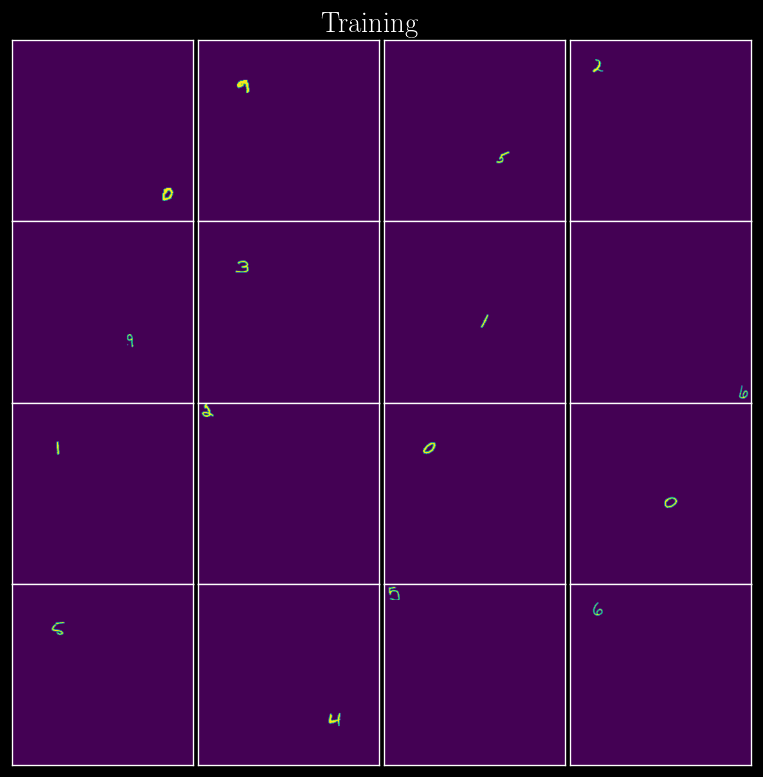

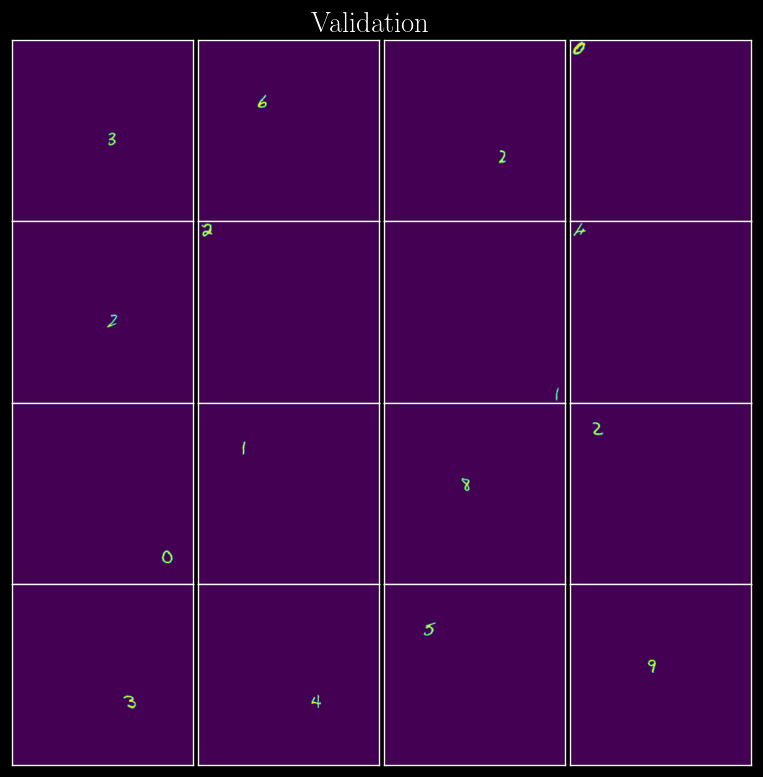

In [4]:
fig, axes = plt.subplots(
    4, 4, sharex=True, sharey=True, figsize=(8, 8), dpi=120)
for i, ax in zip(np.random.randint(0, len(trainset), size=16), axes.flatten()):
    ax.imshow(trainset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Training", y=.91)

fig, axes = plt.subplots(
    4, 4, sharex=True, sharey=True, figsize=(8, 8), dpi=120)
for i, ax in zip(np.random.randint(0, len(valset), size=16), axes.flatten()):
    ax.imshow(valset[i][0][0])
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Validation", y=.91)

In [11]:
nfilters = 128
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(280*280, nfilters*(10)**2),
                          #torch.nn.BatchNorm1d(nfilters*(10)**2),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool1d(100,100),
                          torch.nn.Linear(nfilters, 10))
cnn = torch.nn.Sequential(torch.nn.Conv2d(1, nfilters, kernel_size=28, stride=28),
                          #torch.nn.BatchNorm2d(nfilters),
                          torch.nn.ReLU(),
                          torch.nn.MaxPool2d((10, 1)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(nfilters, 10))  # (10)**2
criterion = torch.nn.CrossEntropyLoss()

# Training some models 

In [6]:
T = 10  # epochs
batch_size = 320
log_step = 1  # validate and print losses every log_steps

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size)

In [7]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
        return loss.item()

In [8]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
    yhat = np.concatenate(yhat)
    out = classification_report(valset.tensors[1], yhat.argmax(axis=1))
    print(out)


def plot_loss():
    plt.plot(np.arange(0, T), losses_train[0:], label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        loss = np.mean(loss)
        losses_train.append(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return losses_train, losses_val

#  CNN Training

In [10]:
# Train the CNN for 100 epochs
cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-2)
losses_train, losses_val = train_loop(cnn,T=T,log_step=log_step)

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
plot_loss()
metrics(cnn)

# LCN Training

In [ ]:
lcn = LCN()
lcn.to(device)

In [ ]:
optimizer = torch.optim.Adam(lcn.parameters(), lr=1e-2)
losses_train, losses_val = train_loop(lcn, T=T, log_step=log_step)

In [ ]:
plot_loss()
metrics(lcn)

# FCN Training

In [ ]:
fcn.to(device)
optimizer = torch.optim.Adam(fcn.parameters(), lr=1e-1)
losses_train, losses_val = train_loop(fcn, T=T, log_step=log_step)

In [ ]:
plot_loss()
metrics(fcn)